# Alignment of 4D NMR spectra using WNetAlign

### Imports

In [ ]:
# !pip install pandas matplotlib seaborn

In [ ]:
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from itertools import combinations

In [ ]:
from nmr.load_spectra import load_spectrum
from nmr.simulate import simulate_4d_shifts
from nmr.nmr_plots import plot_2d_projections_4d
from nmr.metrics import metrics_simulated_CM

In [ ]:
FIG_PATH = "Figures"

In [4]:
FILE_PATH = "4D/2LX7/2LX7_0.1/2LX7_CCNOESY_@ALI.csv"
MAX_PATH = "4D/2LX7/2LX7_0.1_localmax/2LX7_CCNOESY_@ALI_localmax_5.csv"

### Read data

In [5]:
spectrum = load_spectrum(FILE_PATH,
                        dim=4, 
                        scale_nucl={'C':10},
                        max_peak_fraction=None,
                        intensity_threshold=0,
                        verbose=True,
                        )

2LX7
number of peaks: 5844, total signal: 325885213.11



In [6]:
df_max = pd.read_csv(MAX_PATH)
print(df_max.shape)
df_max.head()

(127, 5)


,C1,C2,H1,H2,i
0,33.986535,33.986535,3.725403,-0.419298,33925.117
1,33.986535,33.986535,3.660283,3.680660,50487.293
2,33.986535,33.986535,3.660283,1.002021,36688.125
3,33.986535,33.986535,3.582137,3.625993,38162.020
4,33.986535,33.986535,2.878831,2.860668,38109.984


### Plot 2D projections

C1 C2


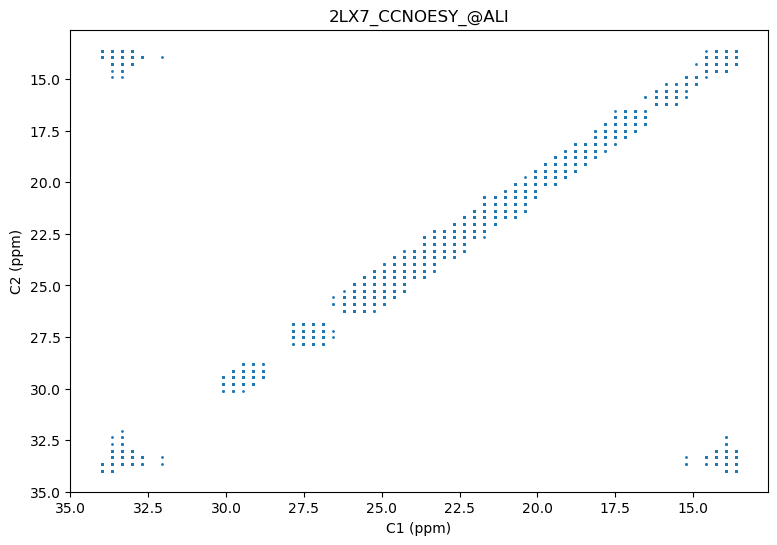

C1 H1


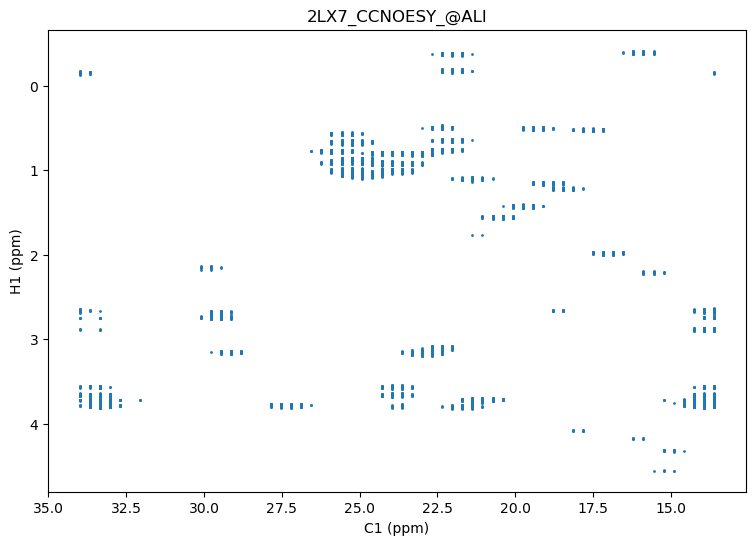

C1 H2


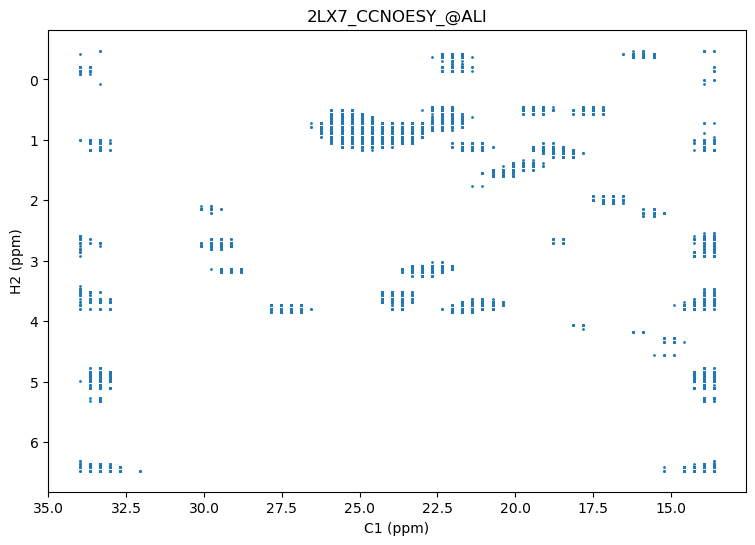

C2 H1


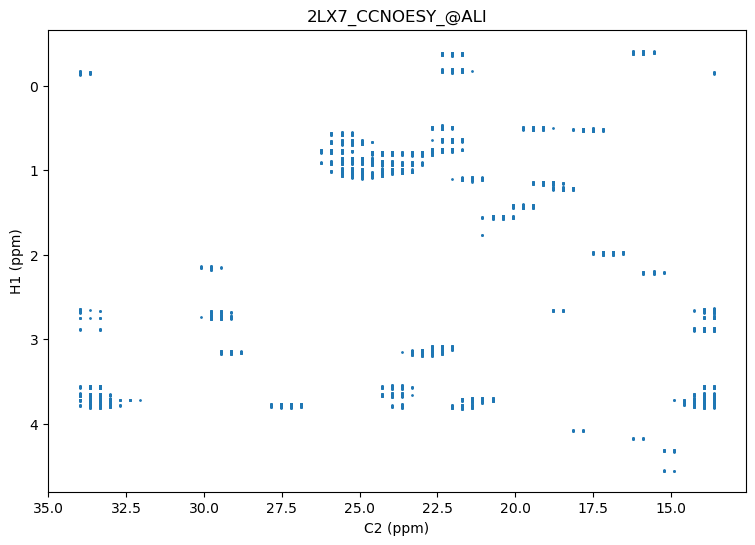

C2 H2


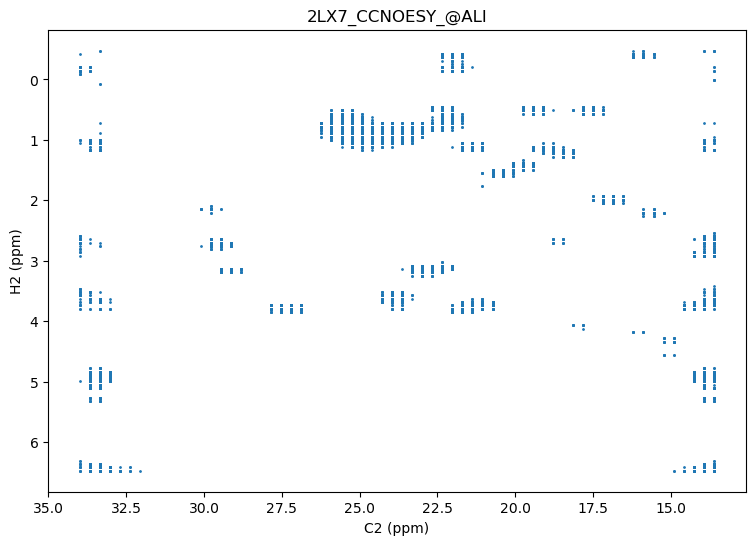

H1 H2


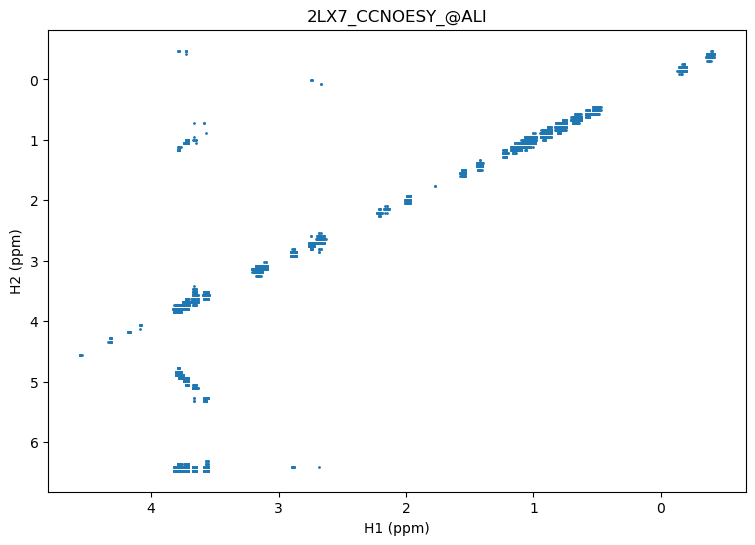

In [7]:
for x_proj, y_proj in combinations(df_max.columns[:4], 2):
    print(x_proj, y_proj)
    plot_2d_projections_4d(FILE_PATH, 
                           x_proj, 
                           y_proj,
                           s=1,
                           figsize=(9, 6)
                          )
    plt.show()

## Simulate replicate spectrum

In [8]:
lims = {'C1': (0.025, 0.045),
        'C2': (0.025, 0.045),
        'H1': (0.015, 0.025),
        'H2': (0.015, 0.025),
       }

OUT_FOLDER="4D/2LX7/2LX7_0.1_simulated/localmax"
OUT_FOLDER = None

simulated_spectrum, spectrum, clusters, shifts = simulate_4d_shifts(file_path=FILE_PATH,
                                                                    clusters_path=MAX_PATH,
                                                                    lims=lims,
                                                                    scale_nucl={"C": 10},
                                                                    dim = 4,
                                                                    OUT_FOLDER = OUT_FOLDER,
                                                                    seed = 0,
                                                                    default_rng = False,
                                                                   )

number of clusters: 127


## Metrics

### Standard metrics

In [10]:
max_distances = [0.01*i for i in range(16, 5, -1)]
trash_costs = [0.01*i for i in range(6, 17)]

metrics_cm_standard = metrics_simulated_CM([spectrum, simulated_spectrum], 
                                           max_distances, 
                                           trash_costs, 
                                           clusters, 
                                           scale_nucl={'C':10}, 
                                           nuclei=['C1', 'C2', 'H1', 'H2'],
                                           extended=False, 
                                           warn=False,
                                          )

[0.8973579611877485, 0.8824537035735616, 0.8900538461731815]
[0.9386980108499096, 0.9751283635651685, 0.9763725697671161]


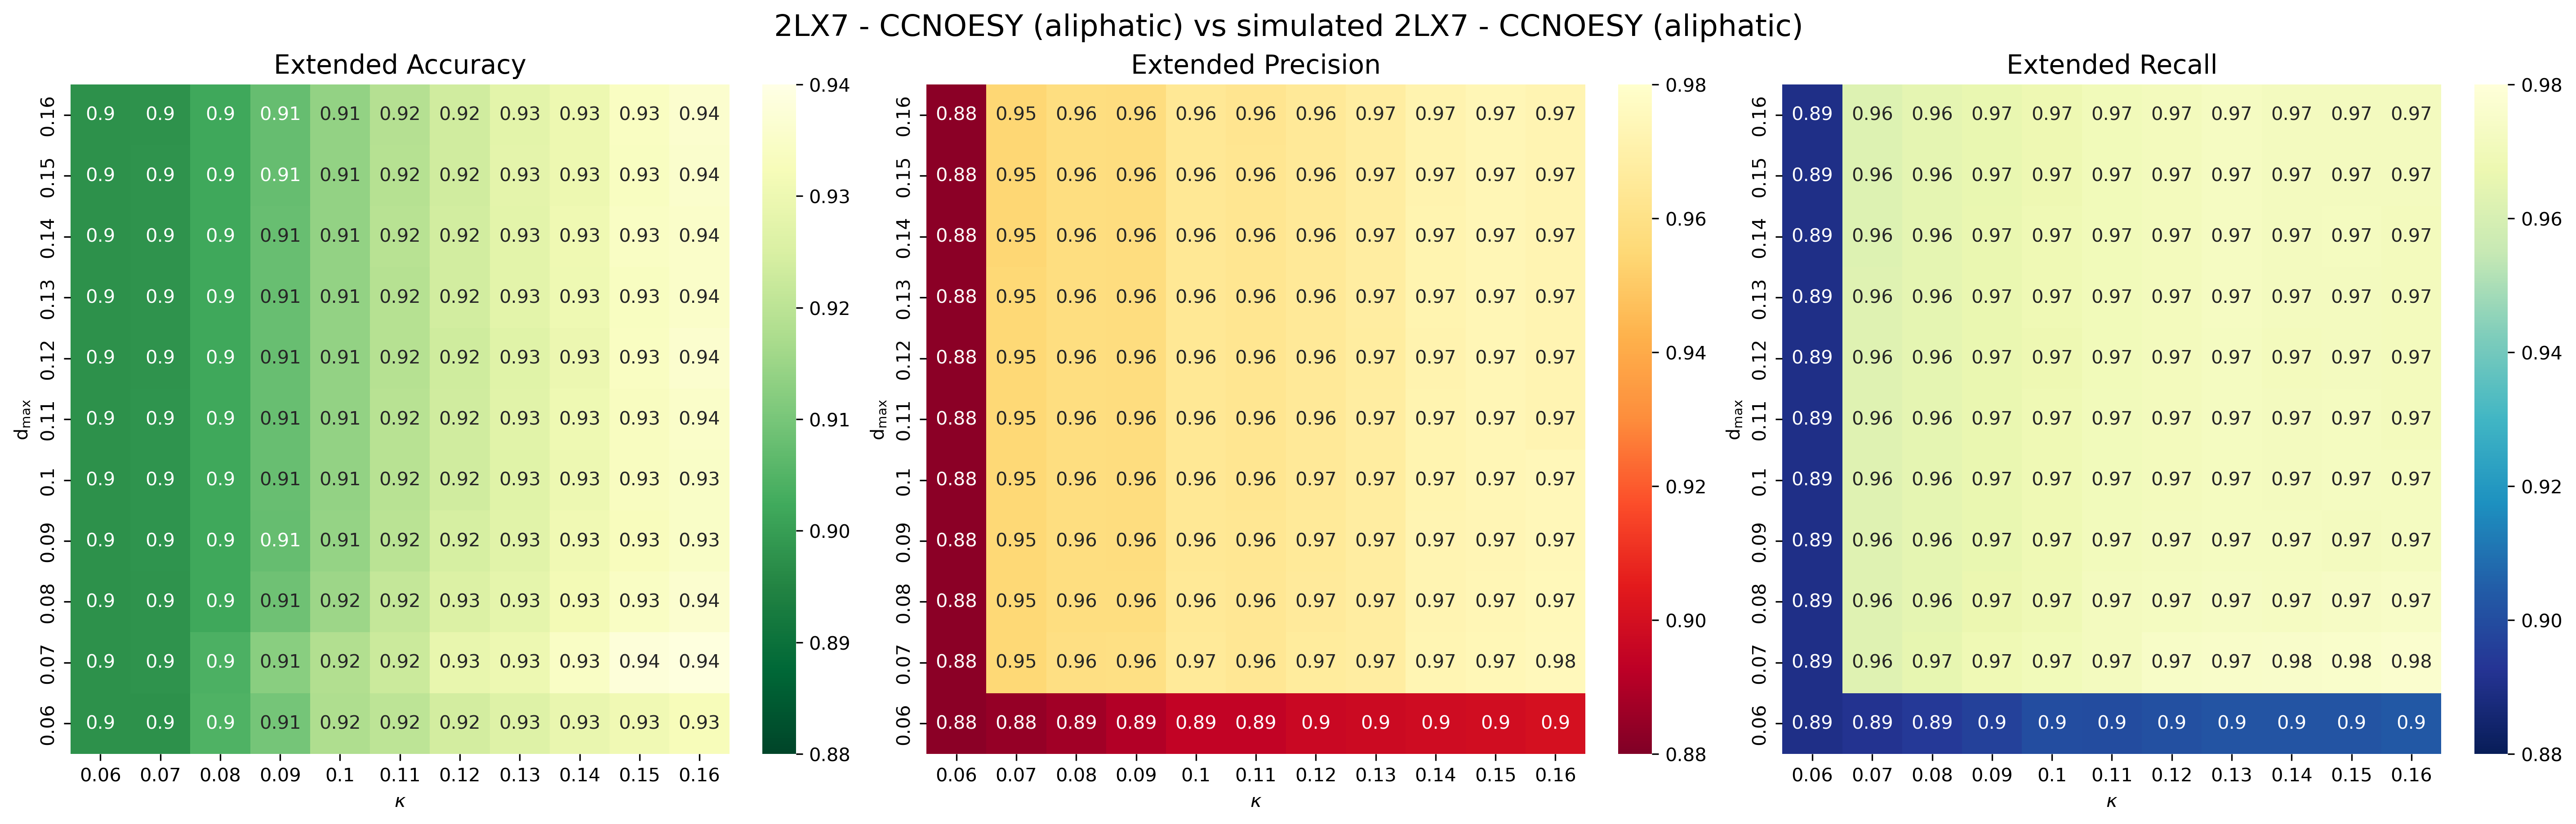

In [26]:
cmap_names = ['BuPu_r', 'OrRd_r', 'GnBu_r', 'OrRd_r', 'GnBu_r']
cmap_names = ['YlGn_r', 'YlOrRd_r', 'YlGnBu_r', 'YlOrRd_r', 'YlGnBu_r']

metric_to_cmap = dict(zip(metrics_cm_standard.keys(), cmap_names))

pad = 5
names = metrics_cm_standard['Accuracy'].keys()

metrics_to_plot = {k: v for k, v in metrics_cm_standard.items() if k in ['Accuracy', 'Precision (macro)', 'Recall (macro)']}
metrics_by_name = {r: {'Accuracy': None, 'Precision (macro)': None, 'Recall (macro)': None} for r in names}

for metric in metrics_to_plot:
    for name in metrics_to_plot[metric]:
        metrics_by_name[name][metric] = metrics_to_plot[metric][name]

cbar_lim = {'Accuracy': (0.88, 0.94), 'Precision (macro)': (0.88, 0.98), 'Recall (macro)': (0.88, 0.98)}

for name in metrics_by_name:

    # vmax = max([m.max().max() for m in metrics_by_name[name].values()])
    # vmin = min([m.min().min() for m in metrics_by_name[name].values()])
    vmax = [m.max().max() for m in metrics_by_name[name].values()]
    vmin = [m.min().min() for m in metrics_by_name[name].values()]
    print(vmin)
    print(vmax)
    
    fig, axes = plt.subplots(nrows=1, ncols=len(cbar_lim), figsize=(6*3+1, 6), constrained_layout=True, squeeze=False, dpi=300)

    for i, metric in enumerate(metrics_by_name[name]):
        sns.heatmap(metrics_by_name[name][metric], 
                    ax=axes[0, i], 
                    vmin=cbar_lim[metric][0], 
                    vmax=cbar_lim[metric][1], 
                    cmap=sns.color_palette(metric_to_cmap[metric], as_cmap=True), 
                    cbar=True, 
                    annot=True,
                   )
        axes[0, i].set(xlabel="$\\kappa$", ylabel="d${_\\text{max}}$")
        axes[0, i].set_title(f"Extended {metric.split(" ")[0]}", fontsize=14)
        
    plt.suptitle(f"{name}", fontsize=16)
    plt.suptitle("2LX7 - CCNOESY (aliphatic) vs simulated 2LX7 - CCNOESY (aliphatic)", fontsize=16)
    plt.savefig(f"{FIG_PATH}/Metrics_4D/Metrics_4D_simulated_localmax_5_{name}.png")
    plt.show()

### Extended metrics

In [12]:
max_distances = [0.01*i for i in range(16, 5, -1)]
trash_costs = [0.01*i for i in range(6, 17)]

metrics_cm_extended = metrics_simulated_CM([spectrum, simulated_spectrum], 
                                           max_distances, 
                                           trash_costs, 
                                           clusters, 
                                           scale_nucl={'C':10}, 
                                           nuclei=['C1', 'C2', 'H1', 'H2'],
                                           extended=True, 
                                           warn=False,
                                          )

[0.41397658744235544, 0.5246595941567427, 0.5598182034635161]
[0.765263004516975, 0.8496391317256399, 0.8971250067293657]


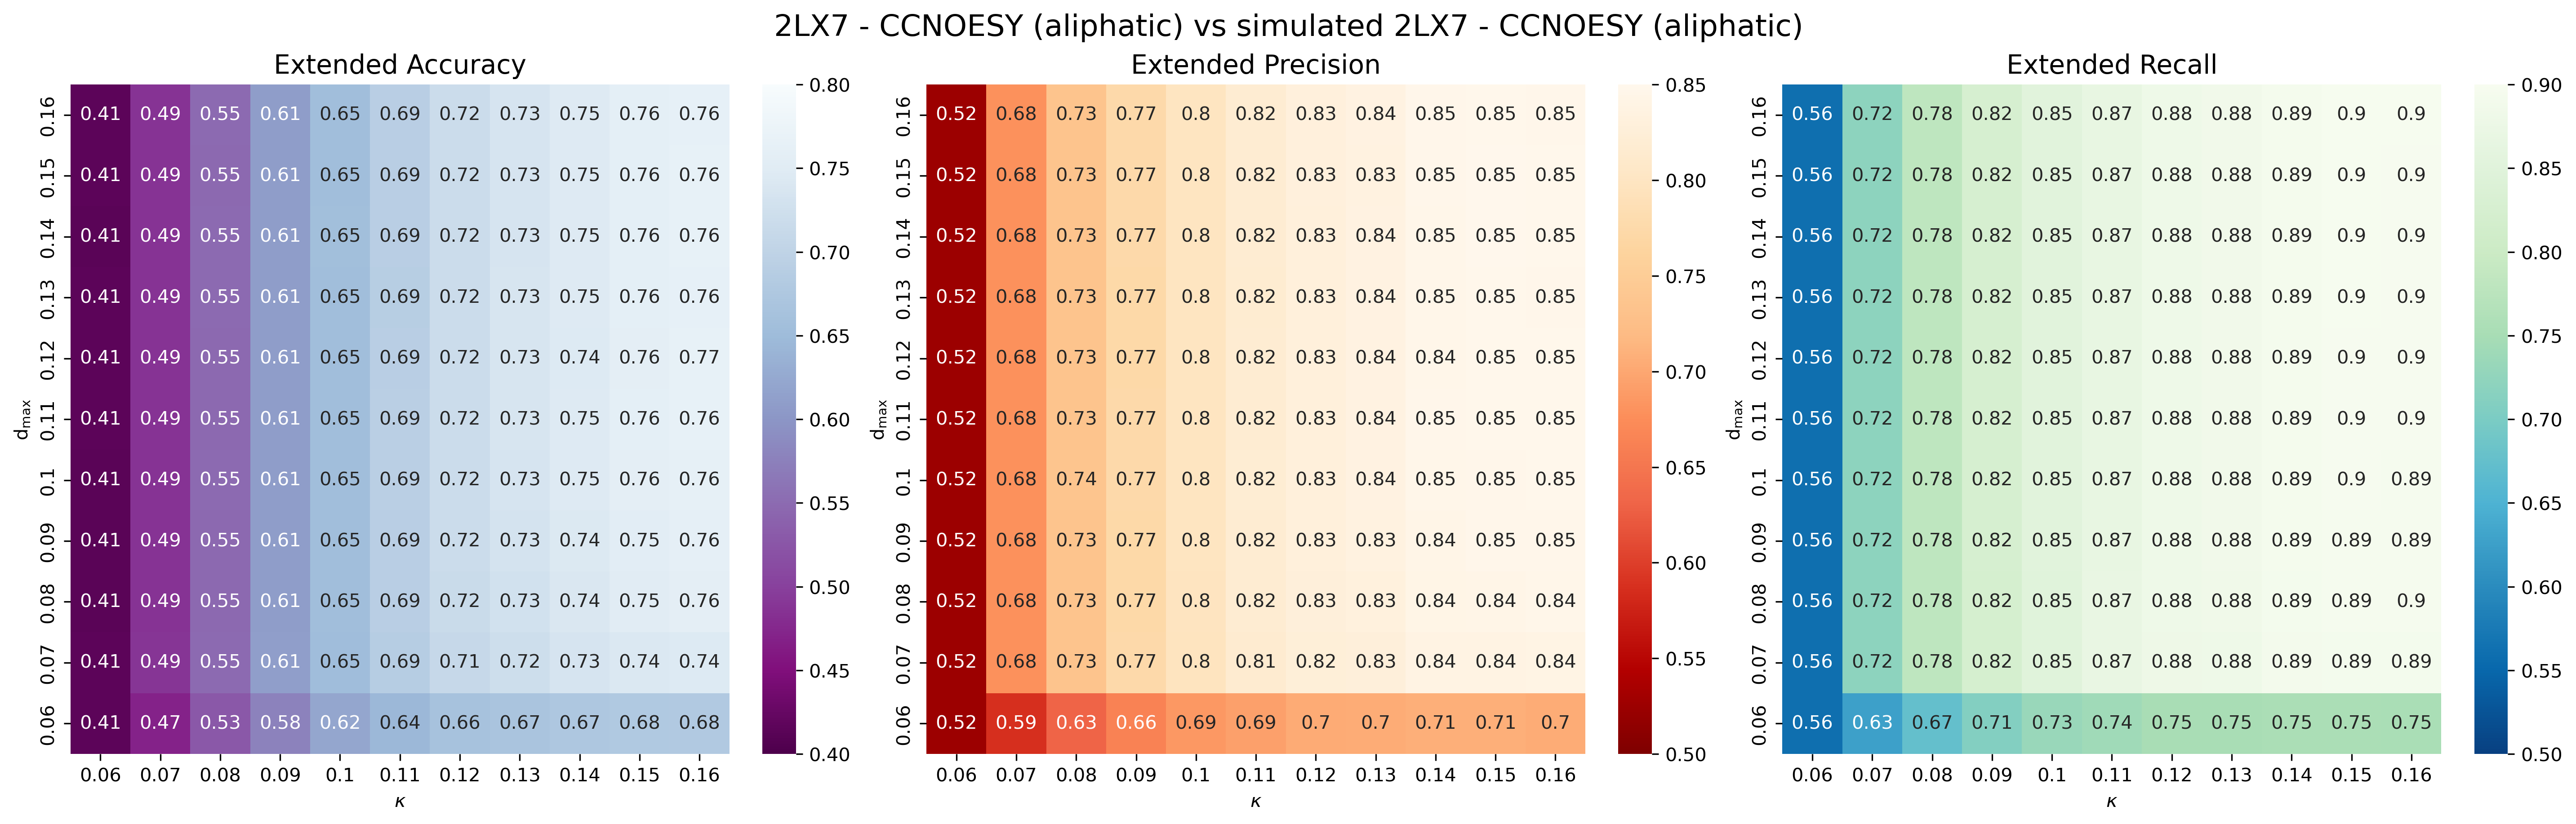

In [27]:
cmap_names = ['BuPu_r', 'OrRd_r', 'GnBu_r', 'OrRd_r', 'GnBu_r']
# cmap_names = ['YlGn_r', 'YlOrRd_r', 'YlGnBu_r', 'YlOrRd_r', 'YlGnBu_r']

metric_to_cmap = dict(zip(metrics_cm_extended.keys(), cmap_names))

pad = 5
names = metrics_cm_extended['Accuracy'].keys()

metrics_to_plot = {k: v for k, v in metrics_cm_extended.items() if k in ['Accuracy', 'Precision (macro)', 'Recall (macro)']}
metrics_by_name = {r: {'Accuracy': None, 'Precision (macro)': None, 'Recall (macro)': None} for r in names}

for metric in metrics_to_plot:
    for name in metrics_to_plot[metric]:
        metrics_by_name[name][metric] = metrics_to_plot[metric][name]

cbar_lim = {'Accuracy': (0.40, 0.8), 'Precision (macro)': (0.50, 0.85), 'Recall (macro)': (0.50, 0.9)}

for name in metrics_by_name:

    # vmax = max([m.max().max() for m in metrics_by_name[name].values()])
    # vmin = min([m.min().min() for m in metrics_by_name[name].values()])
    vmax = [m.max().max() for m in metrics_by_name[name].values()]
    vmin = [m.min().min() for m in metrics_by_name[name].values()]
    print(vmin)
    print(vmax)
    
    fig, axes = plt.subplots(nrows=1, ncols=len(cbar_lim), figsize=(6*3+1, 6), constrained_layout=True, squeeze=False, dpi=300)

    for i, metric in enumerate(metrics_by_name[name]):
        sns.heatmap(metrics_by_name[name][metric], 
                    ax=axes[0, i], 
                    vmin=cbar_lim[metric][0], 
                    vmax=cbar_lim[metric][1], 
                    cmap=sns.color_palette(metric_to_cmap[metric], as_cmap=True), 
                    cbar=True, 
                    annot=True,
                   )
        axes[0, i].set(xlabel="$\\kappa$", ylabel="d${_\\text{max}}$")
        axes[0, i].set_title(f"Extended {metric.split(" ")[0]}", fontsize=14)
        
    plt.suptitle(f"{name}", fontsize=16)
    plt.suptitle("2LX7 - CCNOESY (aliphatic) vs simulated 2LX7 - CCNOESY (aliphatic)", fontsize=16)
    plt.savefig(f"{FIG_PATH}/Extended_metrics_4D/Extended_metrics_4D_simulated_localmax_5_{name}.png")
    plt.show()